## Testing multielectrode GEMsort algorithm using adaptive threshold

In [1]:
from numpy import apply_along_axis as apply
from scipy.signal import fftconvolve
from scipy import signal
from GEMsort_func import GEMsort
from Smoothing_data import Smoothing_filter
from Cut_func import cut
from scipy.signal import butter, lfilter
from copy import deepcopy
from numpy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import struct
import time
import numpy.matlib

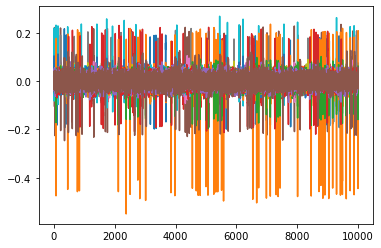

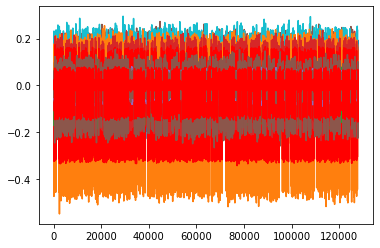

In [2]:
#loading and plotting the data
np.random.seed(10)
# path = '/.../synthetic data' 
path = '/Users/zm6112/Dropbox (Princeton)/PHD_paper_material/new code_use this for postdoc analysis/\
website_all_codes final/JNE_more_analysis/synthetic data'

data=np.load(path + '/multi_16ch_usualdata.npy', allow_pickle=True)
# data = np.load(path + '/multi_16ch_samecells.npy', allow_pickle=True) #this is the similar cells (for two cells)  dataset
# data=np.load(path + '/multi_16ch_sametime.npy', allow_pickle=True) #this is the same firing time (for two cells) dataset

X = data

%matplotlib inline
for i in range(16):
    plt.plot(X[i,:][0:10000])
plt.show()

#Smoothing filter
#%matplotlib qt

for i in range(16):
    data_raw = X[i, :]
    plt.plot(data_raw)
    filtered_data = Smoothing_filter(data_raw, low=10, high=5000, sf=80000, order=2)
    plt.plot(filtered_data, c='r')
#     plt.show()
    
    X[i, :] = filtered_data

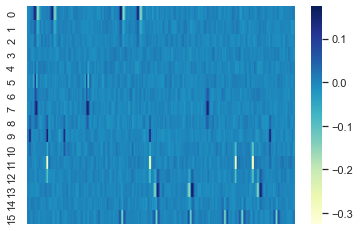

In [3]:
# plot heatmap 
np.random.seed(0)
sns.set_theme()
uniform_data = X[:, 0:2000]
# ax = sns.heatmap(uniform_data, cmap="YlGnBu", xticklabels=False)#, vmin=0.2, vmax=1) #cmap="Greens","BuPu","Blues"
# ax = sns.heatmap(uniform_data, cmap="YlGnBu", xticklabels=False, center=0)#, vmin=0.2, vmax=1)

uniform_data = X[:, 0:1000]
ax = sns.heatmap(uniform_data, cmap="YlGnBu", xticklabels=False)#, vmin=0.2, vmax=1)
# ax = sns.heatmap(uniform_data, cmap="YlGnBu", xticklabels=False, center=0)#, vmin=0.2, vmax=1)

In [4]:
# Initialize the threshold for real-time spike detection.

def initialize_threshold(signal, init_segment_size=5000, K=3):
    init_segment = signal[:init_segment_size]
    initial_std = np.std(init_segment)
    initial_mean = np.mean(init_segment)
    initial_threshold = initial_mean + K * initial_std

    return initial_threshold

# adding dynamic threshold
def calculate_dynamic_threshold(signal, window_size, K):
    if len(signal) < window_size:
        threshold = initialize_threshold
    recent_segment = signal[-window_size:]
    recent_mean = np.mean(recent_segment)
    recent_std = np.std(recent_segment)

    threshold = np.mean(recent_segment) + K * recent_std
#     print('np.mean(recent_segment)=', np.mean(recent_segment))
#     print('threshold=', threshold)
    return threshold

# Example usage:
# Example: data_stream = np.random.normal(0, 1, size=100000)  # Simulated neural data
# window_size = 5000
# K = 3
# current_threshold = calculate_dynamic_threshold(data_stream, window_size, K)


# Assuming X is a 2D array where each row represents a channel
Tdis = 50  
p_all = np.array([], dtype = object).reshape((1,0))
cut_ch = []
ch_num = 16
T1 = 64
# num_win = 10
win_length = 5000  # Length of each streaming data section

num_samples = X.shape[1]  # Total number of samples in the signal

for k in range (ch_num): 
    cut_ch .append([])
    
for i in range(16):  # for every channel
#     x = X[i, :] 
    p = []
    for start in range(0, num_samples, win_length):
#         print(start)
        end = min(start + win_length, num_samples)  
        x_w = X[i, start:end] 

        # Calculate dynamic thresholds using the new function
        Tp = calculate_dynamic_threshold(x_w, window_size=1000, K=3)
        # print('Tp=', Tp)
    
        p_w,_ = scipy.signal.find_peaks(x_w, height = Tp, distance=Tdis)  # Refine peak detection on detected peaks
        p_w += start
        p.append(list(p_w))
    p = np.concatenate(p)
    p = np.array(p)
#     print('p=', p)
    for j in range(np.array(p).shape[0]):
#         print(p[j])
        cut_ch[i].append(cut(X[i, :],p[j],T1)[0])
    
    if p == []:
        p = [0] 
    y_arr = np.array([], dtype = np.int32)
    y = p
    y_arr = np.append(y_arr,y)
    #print(y_arr)
    p_all = np.append(p_all, 0)
#     print(p_all)
    p_all[-1] = y_arr.astype(int) 

/var/folders/5r/j_22d45j5wn_6j9p3016x8p00000gw/T/ipykernel_42053/1842608520.py:67: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if p == []:
/var/folders/5r/j_22d45j5wn_6j9p3016x8p00000gw/T/ipykernel_42053/1842608520.py:67: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if p == []:


In [5]:
start_time = time.time()

a = np.hstack(p_all) 
rowp = a[None, :]

channels = []
times = []

for k in range (np.array(rowp).shape[1]): 
    channels.append([]) 
    times.append([])
        
for k in range (np.array(rowp).shape[1]): #for every peak  
    for i in range (p_all.shape[0]): #number of channels 
        for j in range (p_all[i].shape[0]):
            if all ([p_all[i][j] != 0 and np.abs(p_all[i][j] - rowp[0,k]) < 2 and X[i,rowp[0,k]] != 0]): 
#                 print(p_all[i][j])
#                 print(rowp[0,k])
                channels[k].append(i) #all the channels number with the same peak(k)
                times[k].append(j) #time values for that channel
                
# rowtt = np.unique(rowf)
# for i in range(rowtt.shape[0]):
#     if np.array(rowtt[i]).shape[0] == 1:
#         print(i)
#         channels[1,i] = -1
        
#old_sig = np.copy(signals) 
print("--- %s seconds ---" % (time.time() - start_time))


--- 35.90157079696655 seconds ---


In [6]:
%matplotlib inline

start_time = time.time()
signals_after_corr = deepcopy(cut_ch) 

th_cor = 0.5
maxx = np.zeros((1,np.array(rowp).shape[1]))
zeross = 0 #this is the total number of peaks that will set to zero
#for k in range (np.array(rowp).shape[1]): 
for k in range(np.array(rowp).shape[1]): #the peak counter    
    #print rowp[0][k] 
    #print(k)

    if all ([channels[k] != [] and np.array(channels[k]).shape[0] != 1]) : 
        #repetitive elements of rows since they have different rowp (peak time)
        #print(channels[k])
        maxx[0,k] = -999999
        #print(k)
        for p in range (np.array(channels[k])[:, None].shape[0]) : #considering number of same peaks in every group           
            #print p
            for t in range (np.array(channels[k])[:, None].shape[0]):
#                 print(t)
#                 print(p)

#below condition checks that channels be near each other (less than 3)             
                if all ([channels[k][p] != channels[k][t] and np.abs(channels[k][p]-channels[k][t]) < 3 and np.any(signals_after_corr[channels[k][p]][times[k][p]]) != 0 and np.any(signals_after_corr[channels[k][t]][times[k][t]]) != 0]):                 
                    #print(channels[k][p])
                    #print(channels[k][t])
                    corr = np.corrcoef(signals_after_corr[channels[k][p]][times[k][p]], signals_after_corr[channels[k][t]][times[k][t]])[0, 1]
                    #corr = np.correlate(cut_ch[channels[k][p]][k], cut_ch[channels[k][t]][k])
                    #plt.plot(signals_after_corr[channels[k][p]][times[k][p]],'r')
                    #plt.plot(signals_after_corr[channels[k][t]][times[k][t]])
                    plt.show()
                    print(corr)
                    if corr >= th_cor:  #if correlation is more than the threshold
#                         print('rowp=', channels[k][p])
#                         print('rowt=', channels[k][t])
                        if np.abs(X[channels[k][p],rowp[0, k]]) >= maxx[0, k]:
                            maxx[0, k] = np.abs(X[channels[k][p],rowp[0, k]])
                            #print(maxx[0,k])
                        else:    
                            signals_after_corr[channels[k][p]][times[k][p]] = np.zeros((1, T1)) #if that signal is not the max for correlation remove it 
                            zeross = zeross + 1
                            #print('rowp', channels[k][p]) #number of channel which is removed
                        if np.abs(X[channels[k][t],rowp[0, k]]) > maxx[0, k]: #X[...] is the amount of cut_ch (spike) in peak k
                            maxx[0, k] = np.abs(X[channels[k][t],rowp[0, k]])
                            signals_after_corr[channels[k][p]][times[k][p]] = np.zeros((1, T1))
                            #print('rowp', channels[k][p])
                            #print(maxx[0,k])
                            zeross = zeross + 1
                        else:    
                            signals_after_corr[channels[k][t]][times[k][t]] = np.zeros((1, T1))
                            zeross = zeross + 1
                        #print(maxx[0,k])    
print("--- %s seconds ---" % (time.time() - start_time))
                                

0.9635651662589761
0.8665435625013806
0.9431160230629724
0.9606963743437728
0.9341762252982649
0.9117421104145281
0.9393189931158201
0.931813979000826
0.9620446526947345
0.941279688529057
0.9742479962846303
0.912469261401117
0.9629863623224681
0.9706745306564051
0.9362495769527892
0.9535567989918543
0.9610393654521933
0.7110605375863377
0.8130299608833766
0.9029074379537229
0.8926122073028744
0.8308931011919772
0.965539882282451
0.9503079036715697
0.7068764075948255
0.9408124030673372
0.909956086498898
0.824759362411221
0.970212552972139
0.8421843005129868
0.9205017960429209
0.9430703484037588
0.8581647857341972
0.9455614924670286
0.8224846742969996
0.9545851761856848
0.837523262246896
0.9193432022869539
0.9452822323731384
0.9508419966528493
0.9696473737063583
0.9365273723487553
0.9392880257056924
0.9380723096429165
0.9178582081250114
0.8668299490084508
0.9533639754224036
0.9444459029139948
0.764571589326159
0.909469258568051
0.9441844456811165
0.9328120544732607
0.9020958217616583
0.9

In [7]:
# calculating total number of spikes
t = 0

for i in range (16):
    for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak
        if np.any(np.array(signals_after_corr[i])[k]) != 0:
            t = t+1
    print(i+1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


/var/folders/5r/j_22d45j5wn_6j9p3016x8p00000gw/T/ipykernel_42053/803764875.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for k in range (np.array(signals_after_corr[i]).shape[0]): #for every peak
/var/folders/5r/j_22d45j5wn_6j9p3016x8p00000gw/T/ipykernel_42053/803764875.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.any(np.array(signals_after_corr[i])[k]) != 0:


16


In [8]:
colors =['dodgerblue', 'skyblue', 'gray','deeppink','orange','saddlebrown','lawngreen', 'g','black','cyan','red','brown','lightgray','yellow','pink','magenta']
col = colors[7]

#plt.plot(np.array(cluster[3])[:, 0],np.array(cluster[3])[:, 1], col) 

In [9]:
for i in range(np.array(signals_after_corr).shape[0]):
    final_spikes = []
    for j in range(np.array(signals_after_corr[i]).shape[0]):
        if np.all(signals_after_corr[i][j] == 0): 
            True_sig = 1  #print(cut_ch[i][j])
        else:
            final_spikes.append(signals_after_corr[i][j])
    if final_spikes != []:        
#         print(i + 1) 
        res = np.array(final_spikes)       
        varcovmat = np.cov(res.T)
        k = np.array(np.mean(res.T,1))
        tt = []
        for s in range(res.shape[0]):
            tt.append(k)
        varcovmat = res.T - np.array(tt).T

        u, s, v = svd(varcovmat)
        pca_data = np.dot(res,u[:,0:2])
        pca_data.shape

#         plt.scatter(pca_data[:,0],pca_data[:,1],c=colors[i])

#         #plt.xlim([-400,400])
#         #plt.ylim([-300,300])
#         plt.show()


/var/folders/5r/j_22d45j5wn_6j9p3016x8p00000gw/T/ipykernel_42053/849941517.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for i in range(np.array(signals_after_corr).shape[0]):
/var/folders/5r/j_22d45j5wn_6j9p3016x8p00000gw/T/ipykernel_42053/849941517.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for j in range(np.array(signals_after_corr[i]).shape[0]):


/var/folders/5r/j_22d45j5wn_6j9p3016x8p00000gw/T/ipykernel_42053/1062745895.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for j in range (np.array(signals_after_corr[i]).shape[0]):
/var/folders/5r/j_22d45j5wn_6j9p3016x8p00000gw/T/ipykernel_42053/1062745895.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if (np.any(np.array(signals_after_corr[i])[j]) != 0):
/var/folders/5r/j_22d45j5wn_6j9p3016x8p00000gw/T/ipykernel_42053/1062745895.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple 

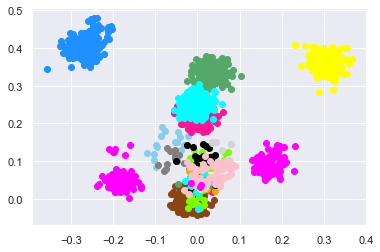

In [10]:
#Getting PCA of the data

num = t #this is calculated in the previous cell, giving the number of non-zero signals    
res = np.zeros((num, T1)) #put non-zero elements in res as arrays
chnum = np.zeros((num, 1)) #contains the channel number label for colors in plotting 

#for determining the labels and groups of clusters

clus_spike = []
for i in range(16):
    clus_spike.append([])

p = 0
for i in range (16):
    for j in range (np.array(signals_after_corr[i]).shape[0]):
        if (np.any(np.array(signals_after_corr[i])[j]) != 0): 
#             while p < np.array(signals_after_corr[i])[j].shape[0]:
            res[p,:] = np.array(signals_after_corr[i])[j]
            chnum[p,0] = i
            data_ch = [i] 
            p = p + 1
            clus_spike[i].append(np.array(signals_after_corr[i])[j])
                                  
#np.save('clus_spike', clus_spike)            

varcovmat = np.cov(res.T)
k = np.array(np.mean(res.T,1))
tt = []
for i in range(res.shape[0]):
   tt.append(k)
varcovmat = res.T - np.array(tt).T

u, s, v = svd(varcovmat)
pca_data = np.dot(res,u[:,0:2])
pca_data.shape

for i in range(chnum.shape[0]):    
    plt.scatter(pca_data[i,0],pca_data[i,1], c=colors[int(chnum[i,0])])
                
#plt.xlim([-400,400])
#plt.ylim([-300,300])
plt.show()



In [17]:
T_cluster = 50 # threshold for the number of spikes to be considered as a cluster

ch_num = 16
all_sorted_size_after=[]
for s in range(ch_num):
#     print('s=',s)
    ch_pca = []
    for i in range(pca_data.shape[0]): 
        #print(int(chnum[i,0]))
        if s == int(chnum[i,0]):
            ch_pca.append(list(pca_data[i,:]))
    ch_pca = np.array(ch_pca)  
    if ch_pca.shape[0] > T_cluster:
        prenumnode = 7 
        GEMsort_dataset = ch_pca
        all_sorted_size_after.append(ch_pca.shape[0])
        Nodes,GEMsort_C,GEMsort_w, nodes_total,prenumnode,d,nodess = GEMsort(prenumnode, GEMsort_dataset)
        
        for i in range(GEMsort_C.shape[0]):
            for j in range (GEMsort_C.shape[0]):
                if GEMsort_C[i,j] != -1:
                   # print i,j
                    x = [GEMsort_w[i,0],GEMsort_w[j,0]]
                    y = [GEMsort_w[i, 1], GEMsort_w[j, 1]]


In [18]:
all_sorted_size_after

[325, 201, 254, 256, 268, 292, 61, 225]

## calculating F1 score and other parameters


In [19]:
# the original clusters information
original_cells_spikes_count = np.array([323, 155, 282, 261, 254, 457, 269, 279]) # this comes from the making spikes file and it name is as size_clusters_original
all_sorted_size_after = np.array(all_sorted_size_after)

# check their sizes
len1 = original_cells_spikes_count.shape[0]
len2 = all_sorted_size_after.shape[0]
for i in range(len1-len2):
    if len1 > len2:
        all_sorted_size_after = np.append(all_sorted_size_after, 0)
    elif len2 > len1:
        original_cells_spikes_count = np.append(original_cells_spikes_count, 0)  
tp_i = []
for i in range(original_cells_spikes_count.shape[0]): 
    if original_cells_spikes_count[i]> all_sorted_size_after[i]:
        tp_i.append(all_sorted_size_after[i])
    else:    
        tp_i.append(original_cells_spikes_count[i])
tp = np.sum(tp_i)
fp_i = [] 
for i in range(original_cells_spikes_count.shape[0]):   
    if original_cells_spikes_count[i] < all_sorted_size_after[i]: # kamtar iane eshtebah classify karde
        fp_i.append(all_sorted_size_after[i]-original_cells_spikes_count[i])
fp = np.sum(fp_i)
fn_i = [] 
for i in range(original_cells_spikes_count.shape[0]):   
    if original_cells_spikes_count[i] > all_sorted_size_after[i]: # bishtar iane classify nakarde un meghdaro
        fn_i.append(original_cells_spikes_count[i]-all_sorted_size_after[i])
fn = np.sum(fn_i)
acc = tp/np.sum(tp + fp + fn)
pre = tp/np.sum(tp + fp)
rec= tp/np.sum(tp + fn)
F1 = (2*tp)/np.sum((2*tp) + fp + fn)

In [23]:
path = "/.../New figures/Adaptive_threshold/"
# np.save(path + 'F1_normal_data', F1)  # for normal data
# np.save(path + 'F1_same_cell', F1) # for the same cell data
# np.save(path + 'F1_same_time', F1) # for the same time data

In [24]:
# load the data to make a table
F1_normal_data = np.load(path + 'F1_normal_data.npy')
F1_same_cell = np.load(path + 'F1_same_cell.npy')
F1_same_time = np.load(path + 'F1_same_time.npy')
print('F1_normal_data=', F1_normal_data)
print('F1_same_cell=', F1_same_cell)
print('F1_same_time=', F1_same_time)

F1_normal_data= 0.8745795290725613
F1_same_cell= 0.8685180634062423
F1_same_time= 0.8514899853444065


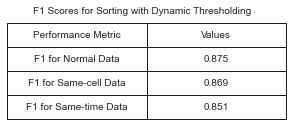

In [26]:
# Create a DataFrame
%matplotlib inline 
data = {
    'Performance Metric': ['F1 for Normal Data', 'F1 for Same-cell Data', 'F1 for Same-time Data'],
    'Values': [np.round(F1_normal_data.item(), 3), \
               np.round(F1_same_cell.item(), 3),\
               np.round(F1_same_time.item(), 3)]}
df = pd.DataFrame(data)

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(5, 2))  # Adjust the size as needed

# Hide axes
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

# Adjust table style
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Add a title
fig.suptitle('F1 Scores for Sorting with Dynamic Thresholding', fontsize=10, y=.95)

# Save the table as a PDF
# plt.savefig(path + 'F1_adaptive_threshold_table.pdf')

# Show the table
plt.show()



